# Component reliability

<div style="background-color:#AABAB2; vertical-align: middle; padding:3px 20px;">
<p>
<b>Solution</b>
</p>
Unfortunately the math equations (defined using Latex) don't work on the website. Hopefully they are readable; if you download and open the notebook in Jupyter or VS Code the equations will display correctly.
</div>

<br>

<div style="background-color:#AABAB2; vertical-align: middle; padding:3px 20px;">
<p>
<b>Task 0:</b>
Tasks to complete during the workshop are provided in boxes like this.
</p>
</div>

<br>

<div style="background-color:#ffffe0; vertical-align: middle; padding:3px 20px;">
<p>
Explanations in the solution are provided in boxes like this.
</div>

<br>

<div style="background-color:#F9E076; vertical-align: middle; padding:3px 20px;">
<p>
    <b>In-class notes:</b> 
</p>
    On Friday our solution notebook had an error in the standard deviation for $M_2$, so the results you saw in class were slightly different.On Friday our solution notebook had an error in the standard deviation for $M_2$, so the results you saw in class were slightly different.
    <br>
    We also discussed several other topics:
<ul>
    <li>c.o.v. is not covariance! (see note below)</li>
    <li>If you re-sample and run MCS, you will see that the result changes slightly due to the variation in values of the sample. This is not a problem if the output (i.e., $p_f$) does not vary so much that your design is affected. It can be adressed by considering the change in estimated $p_f$ and the c.o.v. of the $p_f$, which is desribed in one of the optional MUDE notebooks <a href="https://tudelft-citg.github.io/MUDE/notebooks/contamination/Exercise_Contamination_Render.html#monte-carlo-analysis" target="_blank">link</a>.</li>
    <li>What is the relationship between failure probability and reliability index, $p_f$ and $\beta$? There are three points:
        <ul>
            <li>1) remember we are really trying to integrate a multivariate probability distribution over a specific (failure) region, and to do this we define a limit-state function, which can be represented as a univariate random variable (which is itself a function of random variables). If we assume this random variable is $Z$, we need to simply evaluate the CDF as follows: $p_f=F_Z(0)$. If we know the mean and standard deviation of $Z$ and assume it has the normal distribution, the CDF is simply $\Phi[\frac{0-\mu_Z}{\sigma_Z}]$, and we define $\beta$ as $\beta=\frac{\mu_Z}{\sigma_Z}$. Because we transform our variables and perform computations in the standard normal space, the use of the normal distribution is acceptable.</li>
            <li>2) there is a graphical interpretation of $\beta$: it is this distance from the origin to the design point in the standard normal space (see the textbook). This is easy to visualize for a univariate distribution when beta can be defined as the distance from $\mu_Z$ to 0 in the case outlined previously---try it!</li>
            <li>3) Finally, it is often easier to think of and visualize this number (on the order of 1 to 4 for many applications) than probability, which can be a small number.</li>
            </ul>
</ul>
    
</div>

In this workshop, we will perform a reliability analysis of a structural problem: the reliability of a short column. In particular, we consider a column subjected to biaxial bending moments $M_1$ and $M_2$ and an axial force $P$ and is illustrated below. 

![column sujected to biaxial bending](fig_column_ws02.png "Short column subjected to biaxial bending.")

Assuming an elastic perfectly plastic material with yield strength $y$, the failure of the column is defined by the limit state function:

$$ g(\mathbf{x}) = 1 - \frac{M_1}{s_1 Y} - \frac{M_2}{s_2 Y} - \left(\frac{P}{a Y}\right)^2 $$

where $ \mathbf{x} = \{M_1, M_2, P, Y\}^T $ represents the vector of random variables, $a=0.190 m^2$ is the cross-sectional area, $s_1=0.030 m^2$ and $s_2=0.015 m^2$ are the flexural moduli of the fully plastic column section. Assume $M_1$ and $M_2$ are correlated with a coefficient $\rho=0.5$. The distribution paramaters are given in the table below:

| Variable | Marginal distribution | Mean | c.o.v | 
| --- | --- | --- | --- |
| $M_1$ | Normal | 250 | 0.3 |
| $M_2$ | Normal | 125 | 0.3 |
| $P$ | Gumbel | 2500 | 0.2 |
| $Y$ | Weibull | 40 | 0.1 |

<br>

<div style="background-color:#F9E076; vertical-align: middle; padding:3px 20px;">
<p>
    <b>Note:</b> c.o.v. is <e>coefficient of variation</e>, $\sigma/\mu$. This is another way of defining describing the variance of a random variable, from which the standard deviation can also be found (given the mean is known). Don't confuse this with <e>covariance</e>, $cov$ or $Cov$.
</p>
</div>
We start by importing basic packages.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

The reliability analysis (FORM) will be performed using OpenTURNS, which is a Python package for reliability analyses. You can read more about the packages or the different functions/classes on their [website](https://openturns.github.io), or in the tutorial in the Probabilistic Design chapter of the HOS online textbook.

In [3]:
import openturns as ot
import openturns.viewer as viewer
ot.Log.Show(ot.Log.NONE)

The first steps consist in assigning the problem's variables to python variables: 

In [4]:
a = 0.190
s1 = 0.030
s2 = 0.015

You probably observed that the information above contains each distribution's first and second moments (mean and standard deviation), which for normal distributions is enough to define them on OpenTURNS. However, the Gumbel and Weibull distributions have different distributions parameters, which are defined in OpenTURNS documentation ([Gumbel](https://openturns.github.io/openturns/latest/user_manual/_generated/openturns.Gumbel.html) and [Weibull](https://openturns.github.io/openturns/latest/user_manual/_generated/openturns.WeibullMin.html)). In the context of this workshop, we compute the distribution parameters for you to focus on the analyses; it is however a good exercise to do it yourself later.

The notations adopted below are the one proposed by OpenTURNS and vary from the one of the textbook. Again, mind these differences when using different packages.

The distribution parameters for the Gumbel distribution $Gumbel(\beta, \gamma)$ are such that:

$$ \mathbb{E}[X] = \gamma + \gamma_e \beta $$
$$ \sigma[X] = \frac{\pi \beta}{\sqrt{6}} $$

In [5]:
# Distribution parameters: P (Gumbel distribution)

beta = (np.sqrt(6)*2500*0.2)/np.pi
gamma = 2500 - np.euler_gamma*beta

Likewise, the distribution parameters for the Weibull distribution $Weibull(\beta, \alpha)$ are such that:

$ \mathbb{E}[X] = \beta \Gamma \left(1 + \frac{1}{\alpha} \right) $

$ \sigma [X] = \beta  \sqrt{\left(\Gamma \left(1+\frac{2}{\alpha}\right) - \Gamma^2 \left(1 + \frac{1}{\alpha} \right)\right)} $

By solving the system of equations, we obtain $\beta = 41700$ and $\alpha = 12.2$.

We can finally create random variables objects using OpenTURNS and the distribution parameters compute above.

<div style="background-color:#AABAB2; vertical-align: middle; padding:3px 20px;">
<p>
<b>Task 1:</b>
Define the marginal distributions of the random variables using OpenTURNS.
</p>
</div>
<br>
<div style="background-color:#ffffe0; vertical-align: middle; padding:3px 20px;">
<p>
The solution is in the code cell below.
</div>

In [6]:
M1 = ot.Normal(250, 0.3*250)
M2 = ot.Normal(125, 0.3*125)
P = ot.Gumbel(beta, gamma)
Y = ot.WeibullMin(41700, 12.2)

rho = 0.5    # Correlation coefficient between M1 and M2

As mentioned in the OpenTURNS tutorial, we will be using the PythonFunction class to define our LSF. This requires your LSF to be vectorized, that is allow all the points in a sample to be evaluated without making a for loop : **arguments are vectors, returns too**. 

<div style="background-color:#AABAB2; vertical-align: middle; padding:3px 20px;">
<p>
<b>Task 2:</b>
Define the limit-state function.
</p>
</div>
<br>
<div style="background-color:#ffffe0; vertical-align: middle; padding:3px 20px;">
<p>
The solution is in the code cell below. OpenTURNS will send arguments to the function such that a row defines the value of all random avariables, and expects a single value in return. If there are $N$ samples and $N_{rv}$ random variables, the input and output should be $N$x$N_{rv}$ and $N$x1, respecitvely.
</div>

In [7]:
def myLSF(x):
    ''' 
    Vectorized limit-state function.

    Arguments:
    x: vector. x=[m1, m2, p, y]. 
    '''
    g = [1 - x[0]/(s1*x[3]) - x[1]/(s2*x[3]) - (x[2]/(a*x[3]))**2]
    return g

## Reliability analyses

Then, we define the OpenTURNS object of interest to perform FORM.

<div style="background-color:#AABAB2; vertical-align: middle; padding:3px 20px;">
<p>
<b>Task 3:</b>
Define the correlation matrix for the multivariate probability distribution.
</p>
</div>
<br>
<div style="background-color:#ffffe0; vertical-align: middle; padding:3px 20px;">
<p>
The solution is in the code cell below. As you can see we specify multivariate normal, which requires only a matrix of correlation coefficients. Since the first line generates a correlation matrix of independent random variables by default, and only the first two random variables are correlated, you simply need to add the coefficient to two indices. Remember the matrix is symmetric with elements $\rho_{ij}$.
</div>

In [8]:
# Definition of the dependence structure: here, multivariate normal with correlation coefficient rho between two RV's.
R = ot.CorrelationMatrix(4)   
R[0,1] = rho
R[1,0] = rho
multinorm_copula = ot.NormalCopula(R)

inputDistribution = ot.ComposedDistribution((M1, M2, P, Y), multinorm_copula)
inputDistribution.setDescription(["M1", "M2", "P", "Y"])
inputRandomVector = ot.RandomVector(inputDistribution)

myfunction = ot.PythonFunction(4, 1, myLSF)

# Vector obtained by applying limit state function to X1 and X2
outputvector = ot.CompositeRandomVector(myfunction, inputRandomVector)

# Define failure event: here when the limit state function takes negative values
failureevent = ot.ThresholdEvent(outputvector, ot.Less(), 0)
failureevent.setName('LSF inferior to 0')

### FORM

In [9]:
optimAlgo = ot.Cobyla()
optimAlgo.setMaximumEvaluationNumber(1000)
optimAlgo.setMaximumAbsoluteError(1.0e-10)
optimAlgo.setMaximumRelativeError(1.0e-10)
optimAlgo.setMaximumResidualError(1.0e-10)
optimAlgo.setMaximumConstraintError(1.0e-10)

algo = ot.FORM(optimAlgo, failureevent, inputDistribution.getMean())
algo.run()
result = algo.getResult()
x_star = result.getPhysicalSpaceDesignPoint()        # Design point: original space
u_star = result.getStandardSpaceDesignPoint()        # Design point: standard normal space
pf = result.getEventProbability()                    # Failure probability
beta = result.getHasoferReliabilityIndex()           # Reliability index
print('FORM result, pf = {:.4f}'.format(pf))
print('FORM result, beta = {:.3f}\n'.format(beta))
print(u_star)
print(x_star)

FORM result, pf = 0.0044
FORM result, beta = 2.623

[1.02874,0.593946,0.952835,-2.13509]
[327.156,163.578,2929.16,29789]


<div style="background-color:#AABAB2; vertical-align: middle; padding:3px 20px;">
<p>
<b>Task 4:</b>
Interpret the FORM analysis. Be sure to consider: pf, beta, the design point in the x and u space.
</p>
</div>
<br>
<div style="background-color:#ffffe0; vertical-align: middle; padding:3px 20px;">
From the results printed above:
<ul>
    <li>there is a probability of failure of $p_f$=0.0044, corresponding to $\beta=2.62$</li>
    <li>The design point in the original space, "x_star" or $x^*$ is printed in the last line. Note that the value of $M_1$ is higher than $M_2$ due to the higher mean.</li>
    <li>The design point in the standard normal space, "u_star" or $u^*$, is also printed. It is also interesting because these variables have the standard normal distribution (0 mean and variance 1), and the value gives an idea of "extreme-ness"---how far away from the mean the design point is. We can see that the resistance is -2.1, meaning something over 2$\sigma$ from the mean is expected at failure.</li>
    <li>results from a FORM analysis in OpenTURNS are accessed as attributes of the object "result" which is returned from the method "algo.getResult()"</li>
</ul>
</div>

### MCS

OpenTURNS also allows users to perform Monte Carlo Simulations. Using the objects defined for FORM, we can compute a sample of $g(\mathbf{x})$ and count the negative realisations.

In [10]:
montecarlosize = 10000
outputSample = outputvector.getSample(montecarlosize)

number_failures = sum(i < 0 for i in np.array(outputSample))[0]      # Count the failures, i.e the samples for which g(x)<0
pf_mc = number_failures/montecarlosize                               # Calculate the failure probability                       

In [11]:
print("The failure probability computed with FORM (OpenTURNS) is: ",
      "{:.4g}".format(pf))
print("The failure probability computed with MCS (OpenTURNS) is: ",
      "{:.4g}".format(pf_mc))

The failure probability computed with FORM (OpenTURNS) is:  0.004364
The failure probability computed with MCS (OpenTURNS) is:  0.007


<div style="background-color:#AABAB2; vertical-align: middle; padding:3px 20px;">
<p>
<b>Task 5:</b>
Interpret the MCS and compare it to FORM. What can you learn about the limit-state function?
</p>
</div>
<br>
<div style="background-color:#ffffe0; vertical-align: middle; padding:3px 20px;">
The probabilities are different! This is because FORM uses a linear approximation, and if we sample enough, MCS will approach the "true" value of $p_f$. The difference also tells us about the limit-state function: since FORM has a smaller value, we can tell that the surface is concave towards the origin (see plots below to confirm). Thus, if we were to perform more FORM analyses for different design situations we could expect it to consistently underpredict $p_f$ slightly. This is important, because often when the limit-state function is computationally expensive we prefer to skip MCS and do more FORM analyses. 
</div>

## Importance and Sensitivity

### Importance factors

As presented in the lecture, the importance factors are useful to rank each variable's contribution to the realization of the event. 

OpenTURNS offers built-in methods to compute the importance factors and display them:

[M1 : 0.139562, M2 : 0.139562, P : 0.119726, Y : 0.601151]


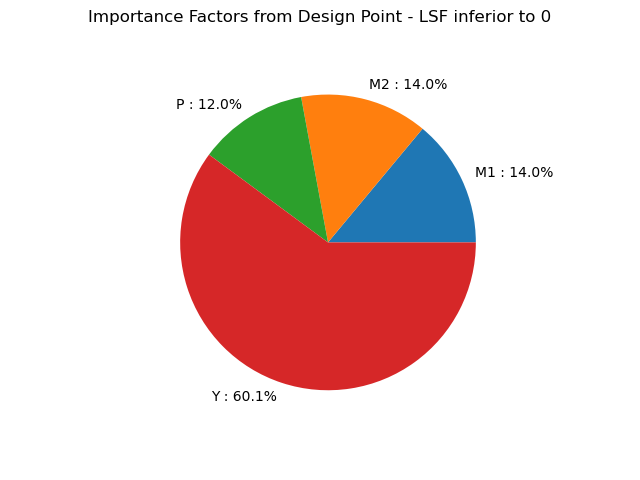

In [12]:
alpha_ot = result.getImportanceFactors()
print(alpha_ot)
result.drawImportanceFactors()

We also compute the importance factors as they are defined in your textbook in order to compare them. 

In [13]:
alpha = u_star/beta
print("The importance factors as defined in the textbook are: ", alpha)

The importance factors as defined in the textbook are:  [0.392274,0.22648,0.363329,-0.814138]


The values given by OpenTURNS are completely different than the one calculated above! When using built-in methods, it is essential to check how they are defined, even when the method's name is explicit. 

**Bonus:** you can figure out the relationship between the textbook's and OpenTURNS formulation by comparing the package's [documentation](https://openturns.github.io/openturns/latest/theory/reliability_sensitivity/importance_form.html#importance-form) and elements of chapter 6 (ADK). 

<div style="background-color:#AABAB2; vertical-align: middle; padding:3px 20px;">
<p>
<b>Task 6:</b>
Interpret the importance factors. Which random variables act as loads or resistances? What is the order of importance?
</p>
</div>
<br>
<div style="background-color:#ffffe0; vertical-align: middle; padding:3px 20px;">
From the results printed above:
<ul>
    <li>observe the sign: variables 1--3 act as loads, variable 4 is a resistance</li>
    <li>observe the magnitude: the resistance has the biggest effect on the result; $M_1$ is the most important load (due to the higher mean value)</li>
    <li>review the formulation of $\alpha$ in the book: it has an interesting geometric interpretation. Also, it is a unit vector, so the variables can be compared to each other consistently. It is based on the gradient of the limit-state function in the u space, and inherently incorporates the transformation from x to u, which implicitly incorporates the probability information of the random variables. This means that $\alpha$ incorporates both functional and stochastic information about the effect of the random variable on the reliability result.</li>
    <li>Note that the OpenTURNS formulation is different: it does not correctly illustrate the different effect of $M_1$ and $M_2$! We recommend you always use the formulation from the ADK book, and always remain suspicious of the terms provided by various software packages (i.e., always check the code and the math!).</li>
    <li></li>
</ul>
</div>

### Sensitivity factors

<div style="background-color:#F9E076; vertical-align: middle; padding:3px 20px;">
<p>
Sensitivity is covered in HW4 and Week 6; it is included here to give you a hint for how it is used in the interpretation of FORM.
</p>
</div>

We can also access the sensitivity of the reliability index $\beta$ with regards to the distribution parameters with the built-in method:

In [14]:
sens = result.getHasoferReliabilityIndexSensitivity()
print("The sensitivity factors of the reliability index with regards to the distribution parameters are: ")
print(sens)

The sensitivity factors of the reliability index with regards to the distribution parameters are: 
[[mean_0_marginal_0 : -0.00348688, standard_deviation_0_marginal_0 : -0.00358711],[mean_0_marginal_1 : -0.00697376, standard_deviation_0_marginal_1 : -0.00717422],[beta_marginal_2 : -0.000956263, gamma_marginal_2 : -0.000569862],[beta_marginal_3 : 9.47416e-05, alpha_marginal_3 : 0.108925, gamma_marginal_3 : 0.000132624],[R_2_1_copula : 0, R_3_1_copula : 0, R_3_2_copula : 0, R_4_1_copula : 0, R_4_2_copula : 0, R_4_3_copula : 0]]


**Interpretation:**

The vectors returned by this method allow us to assess the impact of changes in any distribution parameter on the reliability index, and therefore on the failure probability.

For instance, let us increase the mean of $M_2$ from 125 to 150. Such change would lead to a decrease of $\beta$ of $-0.007 \times 25 = -0.175$. The new failure probability would thus be $ \Phi(-\beta) = \Phi(-(2.565-0.175)) = 0.0084 $, an increase!

## Graphical Interpretation

The difference between the two probabilities above was expected because FORM tends to underestimate the failure probability.

We summarize our findings in two plots. Since $M_2$ and $Y$ have the strongest contributions to the failure probability, we choose to position ourselves in that plane first.

<div style="background-color:#AABAB2; vertical-align: middle; padding:3px 20px;">
<p>
<b>Task 7:</b>
Complete the code below by filling in the missing values of the design point for the plot. Then take a look at the plots and see if you can learn anything about the limit-state function, and whether it is aligned with your FORM and MCS results. If you were designing a structure using the beam in this proble, would you feel comfortable using the design point from this analysis?
</p>
</div>
<br>
<div style="background-color:#ffffe0; vertical-align: middle; padding:3px 20px;">
In the code cell below, you were required to enter the proper design values from the result "x_star".
<br>
From the figure, note:
<ul>
    <li>the limit-sate function is indeed concave toward the mode of the joint distribution (the "mode" is the origin in the u-space).</li>
    <li>Since the variables are independent, the contours are symmetric around each axis.</li>
    <li>We can see that the design point is the point on the limit-state surface that is closes to the center of the contours.</li>
    <li>Imagine how changing the mean or variance of the random variables would change the design point.</li>
</ul>
</div>

In [15]:
def f_m2(m1, p, y):
    ''' Computes m2 given m1, p and y. '''
    return s2*y - m1*s2/s1 - (s2*p**2) /(y*a**2)

def f_m1(m2, p, y):
    ''' Computes m1 given m2, p and y. '''
    return s1*y - m2*s1/s2 - (s1*p**2) /(y*a**2)



y_sample = np.linspace(10000, 50000, 200)
m2_sample = [f_m2(x_star[0], x_star[2], k) for k in y_sample]     # For now, take (Y, M2) plane

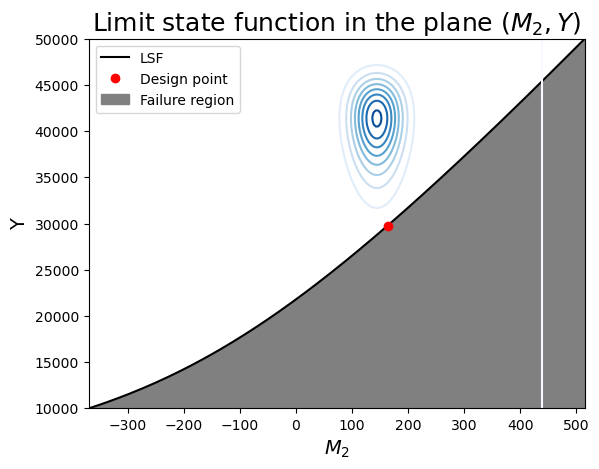

In [16]:
f, ax = plt.subplots(1)

ax.plot(m2_sample, y_sample, label="LSF", color="k")
# Contour plot
X_grid,Y_grid = np.meshgrid(m2_sample,y_sample)
pdf = np.zeros(X_grid.shape)
for i in range(X_grid.shape[0]):
    for j in range(X_grid.shape[1]):
            # This is correct, but only works when ALL RV's are independent!
            # pdf[i,j] = M2.computePDF(X_grid[i,j])*Y.computePDF(Y_grid[i,j])
            pdf[i,j] = inputDistribution.computePDF([x_star[0], X_grid[i,j], x_star[2], Y_grid[i,j]])
ax.contour(X_grid, Y_grid, pdf, levels=8, cmap=cm.Blues)

ax.set_xlabel(r"$M_2$", fontsize=14)
ax.set_ylabel("Y", fontsize=14)
ax.plot(x_star[1], x_star[3], 'ro', label="Design point")    # Delete x_star[1] and x_star[3] for students
ylim = ax.get_ylim()
ax.fill_between(m2_sample, ylim[0], y_sample, color="grey", label="Failure region")
ax.set_title(r"Limit state function in the plane $(M_2, Y)$", fontsize=18)
ax.legend();

<br>
<div style="background-color:#ffffe0; vertical-align: middle; padding:3px 20px;">
From the second figure:
<ul>
    <li>this combination of variables has a more linear limit-state surface (this is not general for the entire problem: we can only visualize 2 variables at a time!)</li>
    <li>you can identify the correlation between $M_1$ and $M_2$ as the inclined axis of the elliptical contours of probability density.</li>
    <li>The design point seems to be correct: it is the highest density on the limit-state surface.</li>
</ul>
</div>

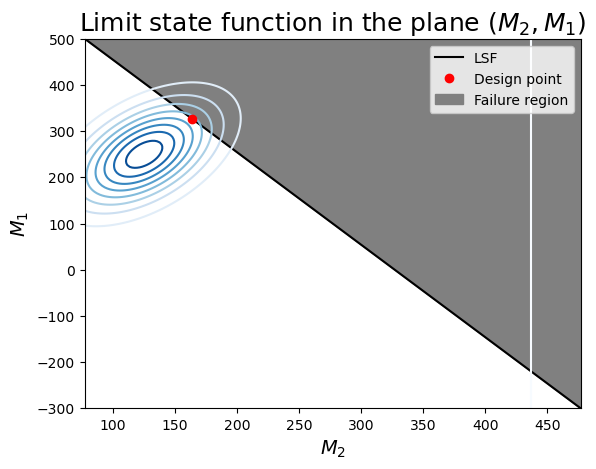

In [17]:
m1_sample = np.linspace(-300, 500, 200)
m2_sample = [f_m2(k, x_star[2], x_star[3]) for k in m1_sample]

f, ax = plt.subplots(1)

ax.plot(m2_sample, m1_sample, label="LSF", color="k")
# Contour plot
X_grid,Y_grid = np.meshgrid(m2_sample,m1_sample)
pdf = np.zeros(X_grid.shape)
for i in range(X_grid.shape[0]):
    for j in range(X_grid.shape[1]):
            # This is correct, but only works when ALL RV's are independent!
            # pdf[i,j] = M2.computePDF(X_grid[i,j])*Y.computePDF(Y_grid[i,j])
            pdf[i,j] = inputDistribution.computePDF([Y_grid[i,j], X_grid[i,j], x_star[2], x_star[3]])
ax.contour(X_grid, Y_grid, pdf, levels=8, cmap=cm.Blues)

ax.set_xlabel(r"$M_2$", fontsize=14)
ax.set_ylabel(r"$M_1$", fontsize=14)
ax.plot(x_star[1], x_star[0], 'ro', label="Design point")    # Delete x_star[1] and x_star[3] for students
ylim = ax.get_ylim()
ax.fill_between(m2_sample, m1_sample, ylim[1], color="grey", label="Failure region")
ax.set_title(r"Limit state function in the plane $(M_2, M_1)$", fontsize=18)
ax.legend();

## Bonus: $M_1$ and $M_2$ connected via the Clayton copula

**Note:** the dependence structure is quite particular. $M_1$ and $M_2$ are correlated, but independent from the other 2 variables (P, Y).  

<div style="background-color:#AABAB2; vertical-align: middle; padding:3px 20px;">
<p>
<b>Task 8:</b>
You do not need to fill out any code in the bonus part. Take a look at the figures and compare them to the original case, which included linear dependence (i.e., bivariate Gaussian) between the two load variables. Pay particular attention to the correlation structure in both plots, and try to understand where it comes from. Note in particular the commented piece of code, which uses an (incorrect) alternative for computing the PDF. Why is it different, and why is it incorrect? This is especially important for the first plot, which compares two random variables which, based on the correlation matrix, independent.
</p>
</div>
<br>
<div style="background-color:#ffffe0; vertical-align: middle; padding:3px 20px;">
In this part we specify non-linear dependence structure between the first two random variables to illustrate the impact dependence can have on reliability results. As a general note, it is easier to define multivariate distributions by specifying the marginal distributions separately from the dependence structure (you can learn more about this in the probability cross-over!). This can be seen above in the way you defined the distributions first for each random variable (the marginal distributions), then defined dependence via a correlation matrix. If the marginal distributions were all normal, this would be a multivariate normal (or Gaussian) distribution. However, the use of non-Normal distributions introduces non-linearity into the problem, which makes the definition of dependence difficult to predict. Even though you think you are defining the relationships between specific variables, there are unintended consequences due to the way the conditional distributions are defined. For example, you add a correlation coefficient to the 1st and 2nd variable and this impacts the distribution of the 4th varialbe $f_{X_4|X_1,X_2,X_3}(X_4|X_1,X_2,X_3)$. This does not have an effect in the first example abvove, but we can clearly see it in the example below!
<br><br>
Note: you don't need to understand the Clayton copula, but it is interesting to recognize that it defines a non-linear dependence structure and is quite easy to specify in OpenTURNS (see first ~10 lines of code below).
    <br><br>
From the figure below:
<ul>
    <li>In the first figure you can see the contours have clearly shifted for the conditional distribution of $Y|M_2$ due to the dependence between $M_1$ and $M_2$.</li>
    <li>In the second figure note the non-elliptical contours. This can be interpreted as decreasing positive dependence for higher values of the variables. Thus, as the loads increase, they differ in magnitude more significantly than at lower values, where they tend to increase and decrease similarly. </li>
    <li>In both figures, and comparing to the previous case, it does not look like dependence has a big impact on the design point (unlike HW3, where there was a big effect!</li>
</ul>
</div>

In [18]:
# Definition of the dependence structure: here, Clayton copula with parameter theta
theta = 2.5
clayton_copula = ot.ClaytonCopula(theta)
indep_copula = ot.IndependentCopula(2)
composed_copula = ot.ComposedCopula([clayton_copula, indep_copula])

inputDistribution_2 = ot.ComposedDistribution((M1, M2, P, Y), composed_copula)
inputDistribution_2.setDescription(["M1", "M2", "P", "Y"])
inputRandomVector_2 = ot.RandomVector(inputDistribution_2)

# Vector obtained by applying limit state function to X1 and X2
outputvector_2 = ot.CompositeRandomVector(myfunction, inputRandomVector_2)

# Define failure event: here when the limit state function takes negative values
failureevent_2 = ot.ThresholdEvent(outputvector_2, ot.Less(), 0)
failureevent_2.setName('LSF inferior to 0')

In [19]:
algo = ot.FORM(optimAlgo, failureevent_2, inputDistribution_2.getMean())
algo.run()
result_2 = algo.getResult()
x_star_2 = result_2.getPhysicalSpaceDesignPoint()
u_star_2 = result_2.getStandardSpaceDesignPoint()
pf_2 = result_2.getEventProbability()
beta_2 = result_2.getHasoferReliabilityIndex()
print('FORM result, pf = {:.4f}'.format(pf_2))
print('FORM result, beta = {:.3f}\n'.format(beta_2))
print(u_star_2)
print(x_star_2)

FORM result, pf = 0.0048
FORM result, beta = 2.586

[0.944368,0.52656,0.960543,-2.14427]
[320.828,165.266,2934.09,29732.5]


In [20]:
outputSample = outputvector_2.getSample(montecarlosize)

number_failures = sum(i < 0 for i in np.array(outputSample))[0]      # Count the failures, i.e the samples for which Z<0
pf_mc_2 = number_failures/montecarlosize

In [21]:
print("The failure probability computed using FORM for M1 and M2 having the bivariate normal distribution is: ",
      "{:.4g}".format(pf))
print("The failure probability computed using MCS for M1 and M2 having the bivariate normal distribution is: ",
      "{:.4g}".format(pf_mc))
print("The failure probability computed using FORM for M1 and M2 having the Clayton copula is: ",
      "{:.4g}".format(pf_2))
print("The failure probability computed using MCS for M1 and M2 having the Clayton copula is: ",
      "{:.4g}".format(pf_mc_2))

The failure probability computed using FORM for M1 and M2 having the bivariate normal distribution is:  0.004364
The failure probability computed using MCS for M1 and M2 having the bivariate normal distribution is:  0.007
The failure probability computed using FORM for M1 and M2 having the Clayton copula is:  0.004849
The failure probability computed using MCS for M1 and M2 having the Clayton copula is:  0.0061


<div style="background-color:#ffffe0; vertical-align: middle; padding:3px 20px;">
By comparing the probabilities, we can see that the different dependence model does not have a huge effect on the result. 
</div>

Let's redraw our plots from above and see how things are different. Can you tell?

In [22]:
y_sample = np.linspace(10000, 50000, 200)
m2_sample = [f_m2(x_star[0], x_star[2], k) for k in y_sample]     # For now, take (Y, M2) plane

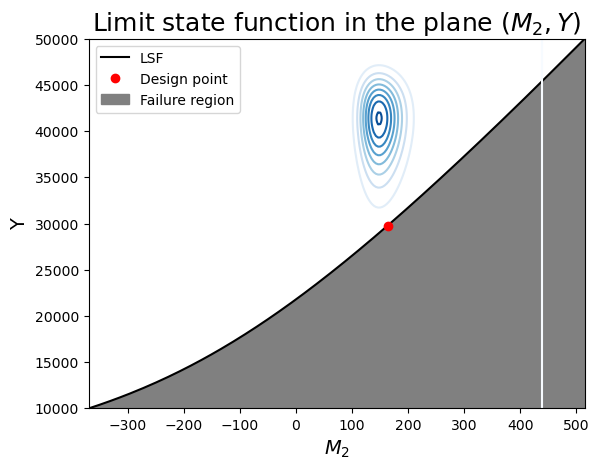

In [23]:
f, ax = plt.subplots(1)

ax.plot(m2_sample, y_sample, label="LSF", color="k")
# Contour plot
X_grid,Y_grid = np.meshgrid(m2_sample,y_sample)
pdf = np.zeros(X_grid.shape)
for i in range(X_grid.shape[0]):
    for j in range(X_grid.shape[1]):
            # This is correct, but only works when ALL RV's are independent!
            # pdf[i,j] = M2.computePDF(X_grid[i,j])*Y.computePDF(Y_grid[i,j])
            pdf[i,j] = inputDistribution_2.computePDF([x_star[0], X_grid[i,j], x_star[2], Y_grid[i,j]])
ax.contour(X_grid, Y_grid, pdf, levels=8, cmap=cm.Blues)

ax.set_xlabel(r"$M_2$", fontsize=14)
ax.set_ylabel("Y", fontsize=14)
ax.plot(x_star[1], x_star[3], 'ro', label="Design point")
ylim = ax.get_ylim()
ax.fill_between(m2_sample, ylim[0], y_sample, color="grey", label="Failure region")
ax.set_title(r"Limit state function in the plane $(M_2, Y)$", fontsize=18)
ax.legend();

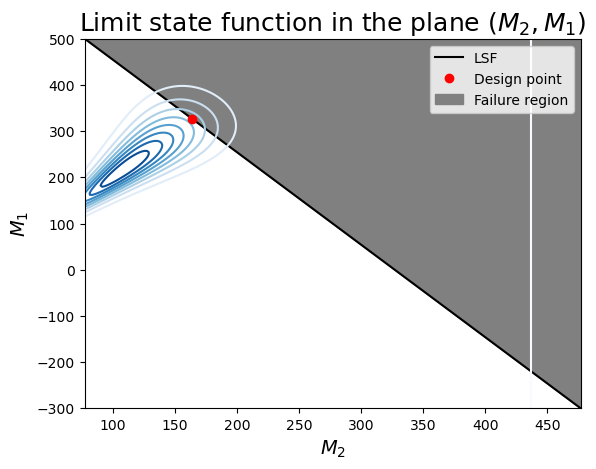

In [24]:
m1_sample = np.linspace(-300, 500, 200)
m2_sample = [f_m2(k, x_star[2], x_star[3]) for k in m1_sample]

f, ax = plt.subplots(1)

ax.plot(m2_sample, m1_sample, label="LSF", color="k")
# Contour plot
X_grid,Y_grid = np.meshgrid(m2_sample,m1_sample)
pdf = np.zeros(X_grid.shape)
for i in range(X_grid.shape[0]):
    for j in range(X_grid.shape[1]):
            # This is correct, but only works when ALL RV's are independent!
            # pdf[i,j] = M2.computePDF(X_grid[i,j])*Y.computePDF(Y_grid[i,j])
            pdf[i,j] = inputDistribution_2.computePDF([Y_grid[i,j], X_grid[i,j], x_star[2], x_star[3]])
ax.contour(X_grid, Y_grid, pdf, levels=8, cmap=cm.Blues)

ax.set_xlabel(r"$M_2$", fontsize=14)
ax.set_ylabel(r"$M_1$", fontsize=14)
ax.plot(x_star[1], x_star[0], 'ro', label="Design point")
ylim = ax.get_ylim()
ax.fill_between(m2_sample, m1_sample, ylim[1], color="grey", label="Failure region")
ax.set_title(r"Limit state function in the plane $(M_2, M_1)$", fontsize=18)
ax.legend();